# Training a triplet loss siamese neural network with stochastic quantization model

Importing all required third-party dependencies

In [1]:
import os
import itertools

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib as mpl
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

from sklearn.metrics import ConfusionMatrixDisplay, f1_score

import sq.optim as sq_optim
import sq.quantization as sq

Choosing a different algorithm for convolutions computations

In [2]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

To enforce reproducibility we set the random seed manually

In [3]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"Used random seed: {torch.initial_seed()}")

Used random seed: 42


We set up the computation device for performing optimization

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"

We will use MNIST dataset of handwritten digits

In [5]:
EPOCHS = 50

BATCH_TRAIN = 1000
BATCH_TEST = 10000
DATA_DIR = "../../data/"
RESULTS_DIR = "../../results/"

TRAIN_SUBSET_SIZE = 1.0

train_dataset = datasets.MNIST(
    root=DATA_DIR, train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

train_subset_idxs = np.random.randint(0, len(train_dataset),
                                      size=int(len(train_dataset) * TRAIN_SUBSET_SIZE))
train_subset = torch.utils.data.Subset(train_dataset, train_subset_idxs)

test_dataset = datasets.MNIST(
    root=DATA_DIR, train=False, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

train_dataloader = DataLoader(train_subset, batch_size=BATCH_TRAIN, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=True)

These are examples of handwritten digits from the dataset

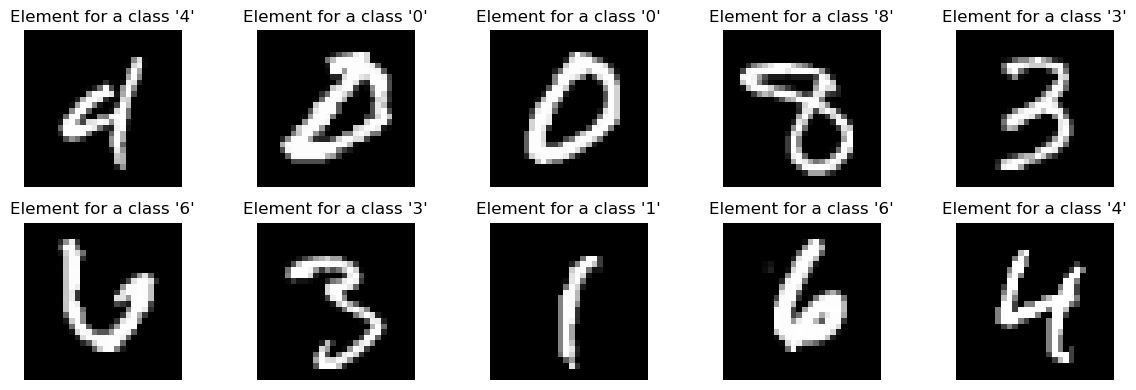

In [6]:
# Selecting random samples for the visual showcase
row_elements = 5

fig, axes = plt.subplots(2, row_elements, figsize=(12, 4), tight_layout=True)

# Display the samples in the image grid
for i, (image, label) in enumerate(
  itertools.islice(train_subset, 2 * row_elements)
):
    row = i // row_elements
    col = i % row_elements

    axes[row, col].imshow(image.squeeze(), cmap="gray")
    axes[row, col].set_title(f"Element for a class '{label}'")
    axes[row, col].axis("off")

# Show the plot
plt.show()

A blueprint for a siamese neural network

In [7]:
class SiameseModel(nn.Module):    
    def __init__(self, latent_dim=3):
        super(SiameseModel, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Flatten(),

            nn.Linear(64 * 7 * 7, 64),
            nn.ReLU(),

            nn.Linear(64, latent_dim),
        )

    def forward(self, x):
        return self.encoder(x)

Triplets are mined as semi-hard category in the online mode

In [8]:
def get_semihard_triplets(embeddings, labels, margin=1.0):
    pairwise_dist = torch.cdist(embeddings, embeddings)

    # Create a mask for positive pairs (same label)
    labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)
    positive_mask = labels_equal.to(embeddings.device)

    # Create a mask for negative pairs (different label)
    negative_mask = ~positive_mask

    # Exclude self-comparisons
    mask_no_self = ~torch.eye(embeddings.shape[0], dtype=torch.bool, device=embeddings.device)
    positive_mask = positive_mask & mask_no_self
    negative_mask = negative_mask & mask_no_self

    # Find hardest positive for each anchor
    hardest_positive_dist, _ = (pairwise_dist * positive_mask.float()).max(dim=1)

    # Find semi-hard negatives for each anchor
    semi_hard_negative_mask = (pairwise_dist > hardest_positive_dist.unsqueeze(1)) & \
                              (pairwise_dist < hardest_positive_dist.unsqueeze(1) + margin) & \
                              negative_mask

    # If no semi-hard negative exists, use the hardest negative
    for i in range(embeddings.shape[0]):
        if not semi_hard_negative_mask[i].any():
            _, hard_negative_idx = (pairwise_dist[i] * negative_mask[i].float()).min(dim=0)
            semi_hard_negative_mask[i, hard_negative_idx] = True

    # Sample triplets
    anchors = []
    positives = []
    negatives = []

    for i in range(embeddings.shape[0]):
        positive_indices = torch.where(positive_mask[i])[0]
        negative_indices = torch.where(semi_hard_negative_mask[i])[0]

        if len(positive_indices) > 0 and len(negative_indices) > 0:
            positive_idx = positive_indices[torch.randint(0, len(positive_indices), (1,))]
            negative_idx = negative_indices[torch.randint(0, len(negative_indices), (1,))]

            anchors.append(embeddings[i])
            positives.append(embeddings[positive_idx].squeeze(0))
            negatives.append(embeddings[negative_idx].squeeze(0))

    return torch.stack(anchors), torch.stack(positives), torch.stack(negatives)

Building an instance of a siamese neural network and training it on a triplet loss

In [9]:
LATENT_DIM = 3
TRIPLET_MARGIN = 1.0

siamese_model = SiameseModel(latent_dim=LATENT_DIM).to(device)
criterion = nn.TripletMarginLoss(margin=TRIPLET_MARGIN, p=2)
optimizer = optim.Adam(siamese_model.parameters(), lr=1e-3, weight_decay=1e-05)

train_loss, val_loss = [], []


for epoch in range(EPOCHS):
    epoch_train_loss = []
    epoch_val_loss = []

    # Training loss and accuracy
    siamese_model.train()

    for images, labels in (progress_bar := tqdm(train_dataloader)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()

        output = siamese_model(images)
        loss = criterion(*get_semihard_triplets(output, labels, margin=TRIPLET_MARGIN))

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_train_loss.append(loss.item())
        progress_bar.set_description(f"Train loss: {loss.item():.4f}")

    train_loss.append(np.mean(np.array(epoch_train_loss)))

    # Validation loss and accuracy
    siamese_model.eval()

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = siamese_model(images)
            loss = criterion(*get_semihard_triplets(output, labels))

            epoch_val_loss.append(loss.item())

    val_loss.append(np.mean(np.array(epoch_val_loss)))

    print(f"Validation loss: {loss.item():.4f}")

Train loss: 0.0149: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.26it/s]


Validation loss: 0.0305


Train loss: 0.0177: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.35it/s]


Validation loss: 0.0212


Train loss: 0.0065: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.35it/s]


Validation loss: 0.0014


Train loss: 0.0064: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.38it/s]


Validation loss: 0.0011


Train loss: 0.0060: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.37it/s]


Validation loss: 0.0005


Train loss: 0.0050: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.39it/s]


Validation loss: 0.0006


Train loss: 0.0052: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.37it/s]


Validation loss: 0.0005


Train loss: 0.0097: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.40it/s]


Validation loss: 0.0003


Train loss: 0.0052: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.39it/s]


Validation loss: 0.0007


Train loss: 0.0407: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.35it/s]


Validation loss: 0.0010


Train loss: 0.0844: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.32it/s]


Validation loss: 0.0007


Train loss: 0.0177: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.35it/s]


Validation loss: 0.0005


Train loss: 0.1112: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.37it/s]


Validation loss: 0.0005


Train loss: 0.0273: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.39it/s]


Validation loss: 0.0005


Train loss: 0.0073: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.35it/s]


Validation loss: 0.0009


Train loss: 0.0051: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.27it/s]


Validation loss: 0.0010


Train loss: 0.0052: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.32it/s]


Validation loss: 0.0008


Train loss: 0.0176: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.36it/s]


Validation loss: 0.0007


Train loss: 0.0072: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.33it/s]


Validation loss: 0.0008


Train loss: 0.0136: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.30it/s]


Validation loss: 0.0010


Train loss: 0.0153: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.33it/s]


Validation loss: 0.0008


Train loss: 0.0135: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.37it/s]


Validation loss: 0.0004


Train loss: 0.0779: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.30it/s]


Validation loss: 0.0008


Train loss: 0.0423: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.28it/s]


Validation loss: 0.0004


Train loss: 0.2036: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.25it/s]


Validation loss: 0.0009


Train loss: 0.0401: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.27it/s]


Validation loss: 0.0008


Train loss: 0.0074: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.35it/s]


Validation loss: 0.0006


Train loss: 0.1298: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.33it/s]


Validation loss: 0.0011


Train loss: 0.0059: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.29it/s]


Validation loss: 0.0008


Train loss: 0.0525: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.33it/s]


Validation loss: 0.0004


Train loss: 0.0469: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.28it/s]


Validation loss: 0.0007


Train loss: 0.1617: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.31it/s]


Validation loss: 0.0009


Train loss: 0.0198: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.28it/s]


Validation loss: 0.0006


Train loss: 0.1649: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.37it/s]


Validation loss: 0.0008


Train loss: 0.1095: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.33it/s]


Validation loss: 0.0009


Train loss: 0.1555: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.35it/s]


Validation loss: 0.0007


Train loss: 0.0703: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.29it/s]


Validation loss: 0.0009


Train loss: 0.0630: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.37it/s]


Validation loss: 0.0007


Train loss: 0.0483: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.32it/s]


Validation loss: 0.0008


Train loss: 0.0567: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.30it/s]


Validation loss: 0.0008


Train loss: 0.0260: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.29it/s]


Validation loss: 0.0009


Train loss: 0.0710: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.27it/s]


Validation loss: 0.0011


Train loss: 0.1156: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.30it/s]


Validation loss: 0.0013


Train loss: 0.0172: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.31it/s]


Validation loss: 0.0008


Train loss: 0.0305: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.29it/s]


Validation loss: 0.0008


Train loss: 0.0457: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.34it/s]


Validation loss: 0.0008


Train loss: 0.1043: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.28it/s]


Validation loss: 0.0012


Train loss: 0.1364: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.33it/s]


Validation loss: 0.0009


Train loss: 0.1192: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.30it/s]


Validation loss: 0.0007


Train loss: 0.2617: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.28it/s]


Validation loss: 0.0009


We convert all handwritten digits from the dataset to visualize their embeddings in the metric space

In [10]:
def group_embeddings_by_label(model: nn.Module, dataloader: DataLoader):
    all_embeddings = np.empty((0, LATENT_DIM))
    grouped_embeddings = {i: np.empty((0, LATENT_DIM)) for i in range(10)}

    for img, lbs in dataloader:
        model_device = next(model.parameters()).device
        batch_embeddings = model(img.to(model_device))
        batch_embeddings = batch_embeddings.cpu().detach().numpy()

        lbs = lbs.detach().numpy()

        for emb, lb in zip(batch_embeddings, lbs):
            grouped_embeddings[lb] = np.vstack((grouped_embeddings[lb], np.array(emb)))

    for cl, embeds in grouped_embeddings.items():
        all_embeddings = np.vstack((all_embeddings, np.array(embeds)))

    return grouped_embeddings, all_embeddings


embedding_model = siamese_model.encoder

with torch.no_grad():
    train_group_embeds, train_all_embeds = group_embeddings_by_label(embedding_model, train_dataloader)
    test_group_embeds, test_all_embeds = group_embeddings_by_label(embedding_model, test_dataloader)

We compare the low-level representations distribution on the 2D scatter plot

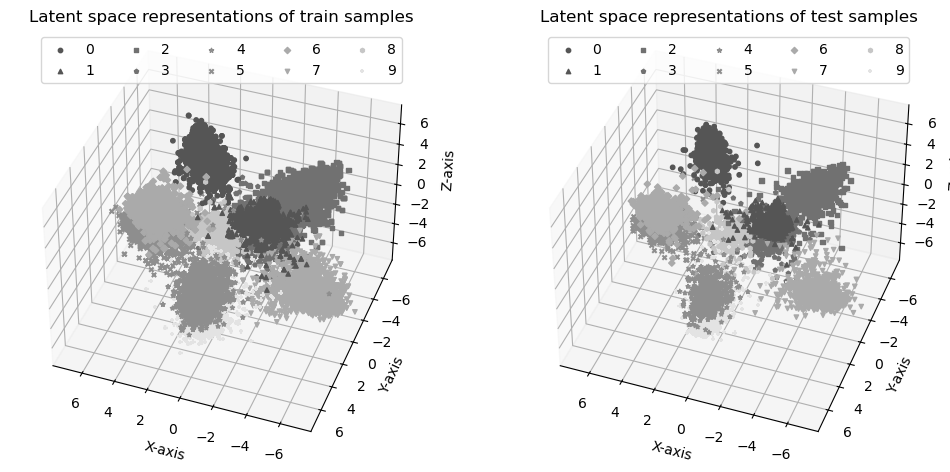

In [11]:
markers = ["o", "^", "s", "p", "*", "x", "D", "v", "h", "+"]
markers_color = mpl.colormaps["gray"].resampled(len(markers))
markers_color_range = np.linspace(0.3, 0.8, len(markers))

marksize = 10
elev, azim = 40, 110

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.view_init(elev=elev, azim=azim, roll=0)

for idx, (cls, embeds) in enumerate(train_group_embeds.items()):
    cls_color = markers_color(markers_color_range[idx])

    ax.scatter(embeds[:, 0], embeds[:, 1], embeds[:, 2], color=cls_color, label=cls,
               alpha=1.0, s=marksize, marker=markers[idx % len(markers)])

ax.legend(loc="upper center", ncol=5)
ax.set_title("Latent space representations of train samples")

ax.set_xlabel("X-axis")
ax.set_xlim((-7.5, 7.5))

ax.set_ylabel("Y-axis")
ax.set_ylim((-7.5, 7.5))

ax.set_zlabel("Z-axis")
ax.set_zlim((-7.5, 7.5))

ax = fig.add_subplot(1, 2, 2, projection="3d")
ax.view_init(elev=elev, azim=azim, roll=0)

for idx, (cls, embeds) in enumerate(test_group_embeds.items()):
    cls_color = markers_color(markers_color_range[idx])

    ax.scatter(embeds[:, 0], embeds[:, 1], embeds[:, 2], color=cls_color, label=cls,
               alpha=1.0, s=marksize, marker=markers[idx % len(markers)])

ax.legend(loc="upper center", ncol=5)
ax.set_title("Latent space representations of test samples")

ax.set_xlabel("X-axis")
ax.set_xlim((-7.5, 7.5))

ax.set_ylabel("Y-axis")
ax.set_ylim((-7.5, 7.5))

ax.set_zlabel("Z-axis")
ax.set_zlim((-7.5, 7.5))

fig.patch.set_facecolor("white")

plt.show()

We will use stochastic quantization algorithm for the non-convex optimization problem of representations clustering

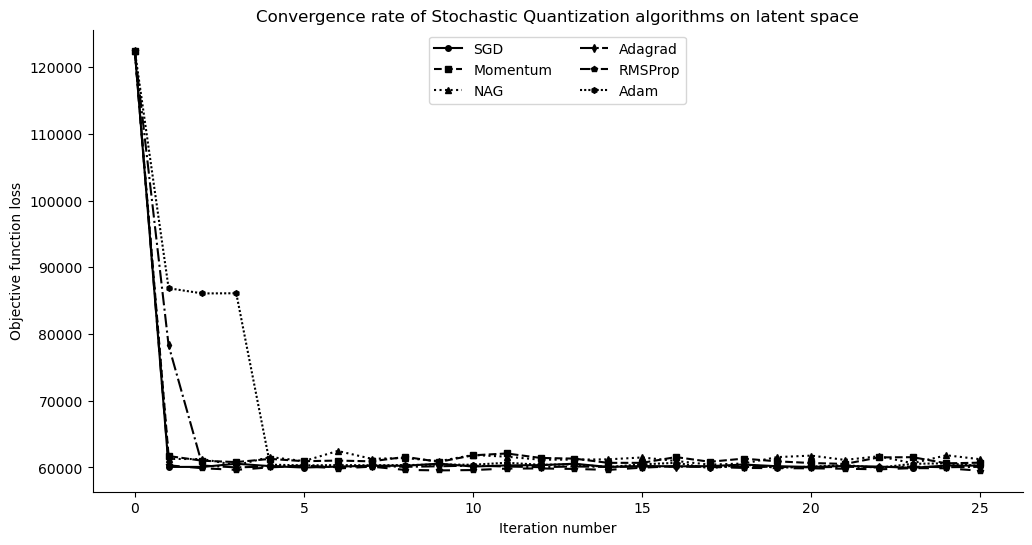

In [12]:
SQ_ITERS = 25

sq_algorithms = {
    "SGD": sq.StochasticQuantization(sq_optim.SGDOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                     random_state=np.random.RandomState(RANDOM_SEED)),
    "Momentum": sq.StochasticQuantization(sq_optim.MomentumOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                          random_state=np.random.RandomState(RANDOM_SEED)),
    "NAG": sq.StochasticQuantization(sq_optim.NAGOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                     random_state=np.random.RandomState(RANDOM_SEED)),
    "Adagrad": sq.StochasticQuantization(sq_optim.AdagradOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                         learning_rate=0.9, random_state=np.random.RandomState(RANDOM_SEED)),
    "RMSProp": sq.StochasticQuantization(sq_optim.RMSPropOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                         learning_rate=0.01, random_state=np.random.RandomState(RANDOM_SEED)),
    "Adam": sq.StochasticQuantization(sq_optim.AdamOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                      learning_rate=0.01, random_state=np.random.RandomState(RANDOM_SEED))
}

markers = [("o", "-"), ("s", "--"), ("^", ":"), ("d", "-."), ("p", (0, (5, 5))), ("h", (0, (1, 1)))]
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for idx, (name, alg) in enumerate(sq_algorithms.items()):
    marker, linestyle = markers[idx % len(markers)]

    alg = alg.fit(train_all_embeds)

    ax.plot(range(len(alg.loss_history_)), alg.loss_history_,
            linestyle=linestyle, marker=marker, color="k",
            markersize=4, label=name)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.title("Convergence rate of Stochastic Quantization algorithms on latent space")
plt.xlabel("Iteration number")
plt.ylabel("Objective function loss")
plt.legend(loc="upper center", ncol=2)
plt.show()

We use confusion matrix to compare the accuracy of classification model for each class

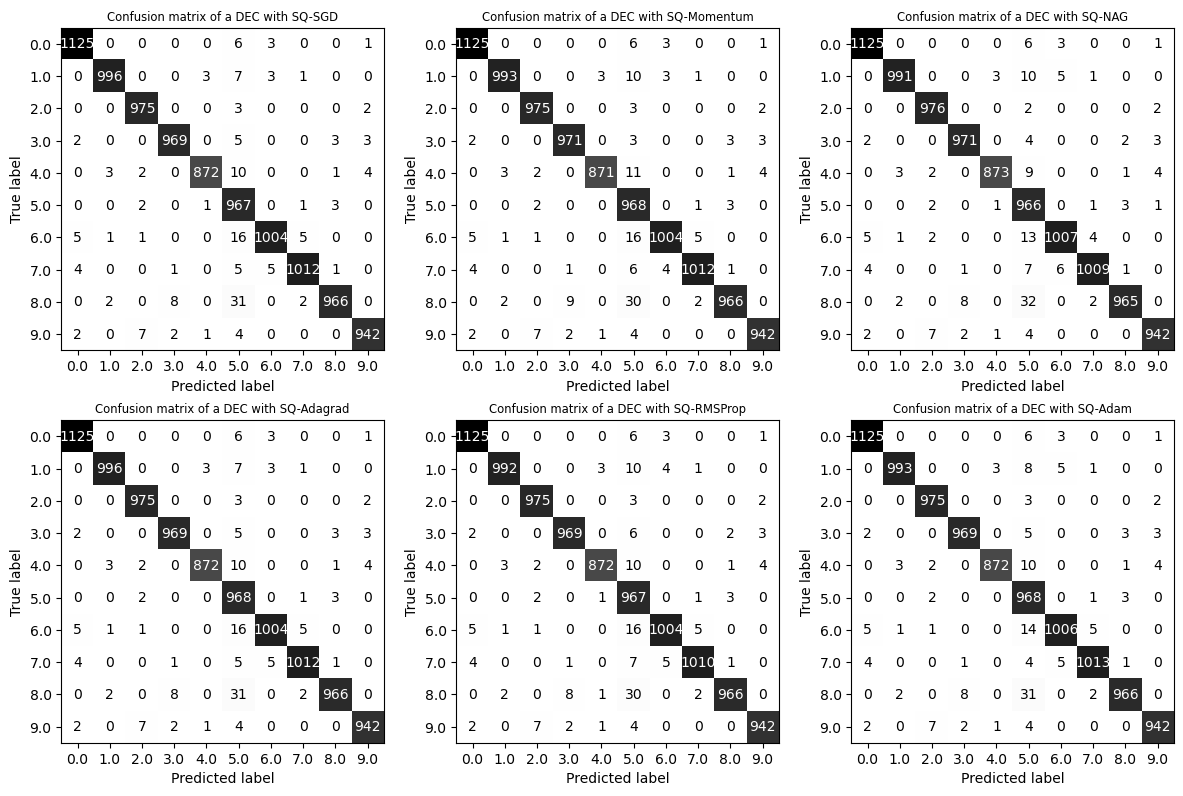

In [13]:
n_col, n_row = (2, 3)
fig, ax = plt.subplots(n_col, n_row, figsize=(12, 8), tight_layout=True)
f1_scores = {}

for idx, (name, alg) in enumerate(sq_algorithms.items()):
    y_true, y_pred = np.array([]), np.array([])

    for _, embs in test_group_embeds.items():
        cls = alg.predict(embs)
        cls_predicted = np.bincount(cls).argmax()

        y_true = np.append(y_true, np.full((1, len(embs)), cls_predicted))
        y_pred = np.append(y_pred, cls)

    ax_idx = ax[idx // n_row, idx % n_row]

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, cmap="Greys", colorbar=False, ax=ax_idx
    )

    ax_idx.set_title(f"Confusion matrix of a DEC with SQ-{name}", size="small")
    f1_scores[name] = f1_score(y_true, y_pred, average="weighted")

plt.show()

To account for label imbalance in the test set, we choose a weighted F1 score as an accuracy metric.

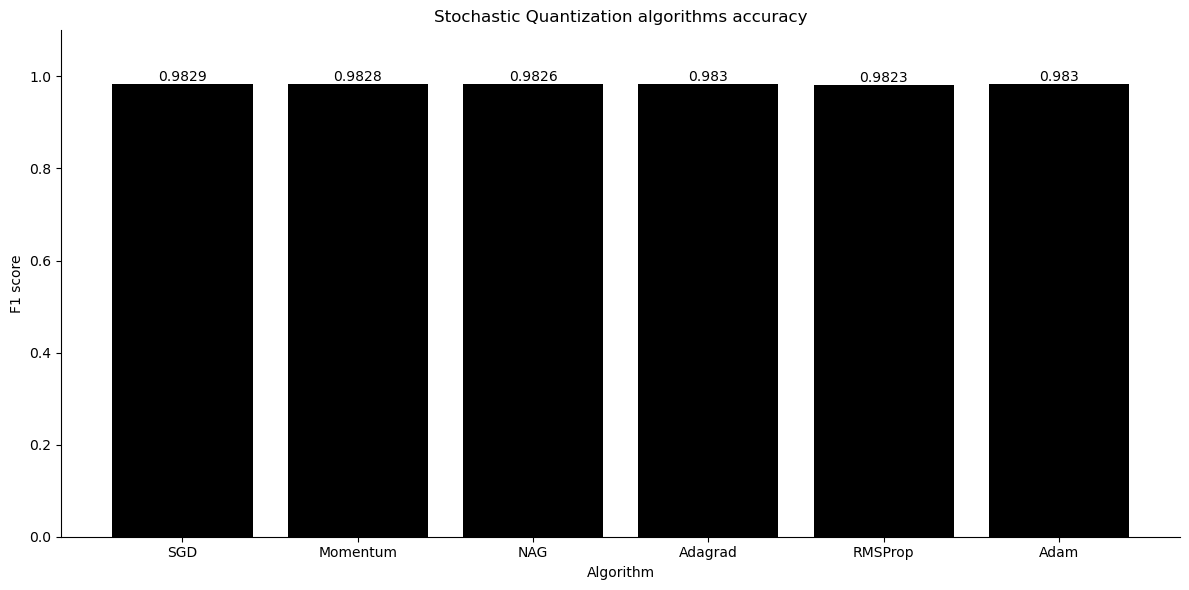

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)

bars = ax.bar(f1_scores.keys(), f1_scores.values(), color="k")

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0,
            height, f"{round(height, 4)}", ha="center", va="bottom")

ax.set_xlabel("Algorithm")
ax.set_ylabel("F1 score")
ax.set_title("Stochastic Quantization algorithms accuracy")
ax.set_ylim(top=1.1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

We can explore the positions of quants for each algorithm against data points in a latent space using a 3D scatter plot. All algorithms managed to converge to the global optimum with similar quant positions.

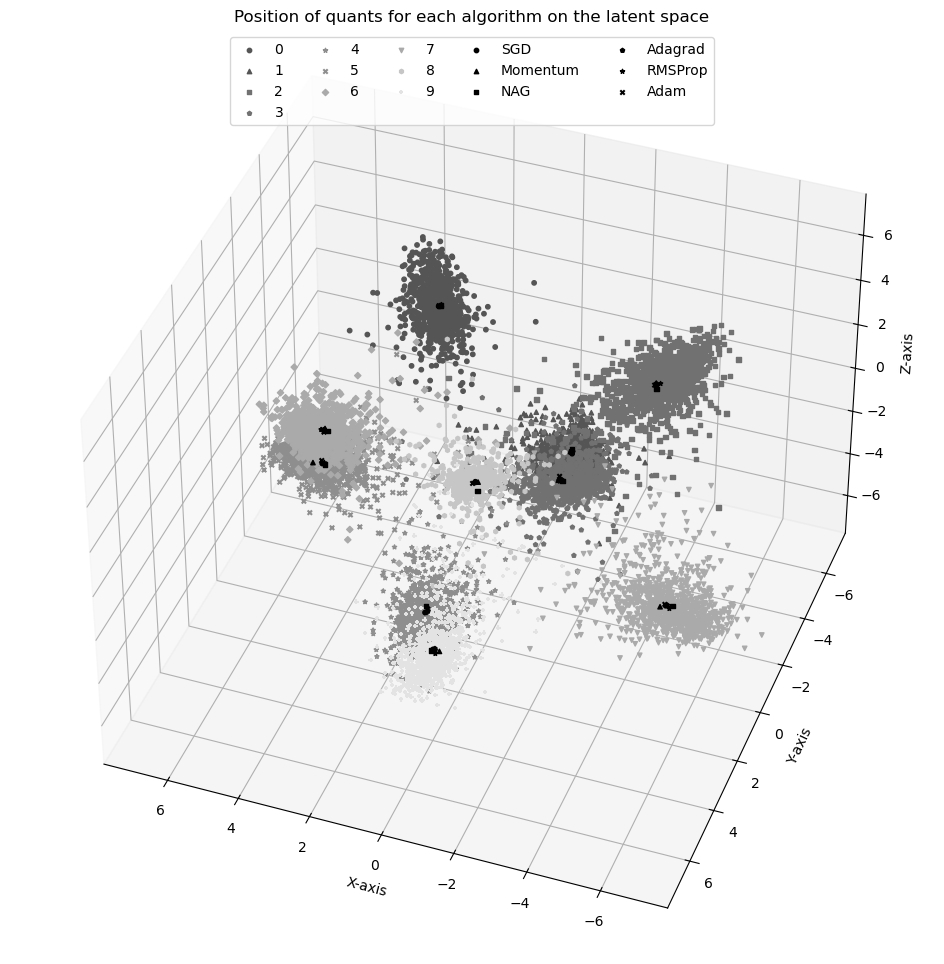

In [15]:
markers = ["o", "^", "s", "p", "*", "x", "D", "v", "h", "+"]
markers_color = mpl.colormaps["gray"].resampled(len(markers))
markers_color_range = np.linspace(0.3, 0.8, len(markers))

marksize = 10

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 1, 1, projection="3d", computed_zorder=False)
ax.view_init(elev=elev, azim=azim, roll=0)

for idx, (cls, embeds) in enumerate(test_group_embeds.items()):
    cls_color = markers_color(markers_color_range[idx])

    ax.scatter(embeds[:, 0], embeds[:, 1], embeds[:, 2], zorder=1, color=cls_color,
               label=cls, alpha=1.0, s=marksize, marker=markers[idx % len(markers)])

for idx, (name, alg) in enumerate(sq_algorithms.items()):
    ax.scatter(alg.cluster_centers_[:, 0], alg.cluster_centers_[:, 1], alg.cluster_centers_[:, 2],
               zorder=2, color="k", label=name, alpha=1.0, s=marksize, marker=markers[idx % len(markers)])

ax.legend(loc="upper center", ncol=5)
ax.set_title("Position of quants for each algorithm on the latent space")

ax.set_xlabel("X-axis")
ax.set_xlim((-7.5, 7.5))

ax.set_ylabel("Y-axis")
ax.set_ylim((-7.5, 7.5))

ax.set_zlabel("Z-axis")
ax.set_zlim((-7.5, 7.5))

fig.patch.set_facecolor("white")

plt.show()

Save encoder model for the later use

In [16]:
MODEL_DIR = os.path.join(RESULTS_DIR, "model")

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

embedding_model.eval()

torch.save(embedding_model.state_dict(), os.path.join(MODEL_DIR, "siamese_model.bin"))